In [1]:
import numpy as np
import pandas as pd

EPOCHS = 70

targets = ['_5HT2A', 'AChE', 'D2R', 'D3R', 'MAOB']
num = [1000, 2000, 5000]

dataframes = {
    target: pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{target}.csv')
    for target in targets
}

dataframes["Unconditional"] = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/Unconditional.csv')

for target in dataframes:
    df = dataframes[target]
    col_preds = df.columns[1]

    count_invalid = len(df[df[col_preds].isna()])
    print(f"{target}: {count_invalid}")

    # Drop invalid smiles rows
    dataframes[target] = df.dropna(subset=[col_preds]).copy()
    # Set dtype as float for every column except SMILES
    for col in df.columns:
        if col != 'SMILES':
            dataframes[target][col] = dataframes[target][col].astype(float)

    print(dataframes[target].shape)

_5HT2A: 4185
(25815, 7)
AChE: 5338
(24662, 7)
D2R: 3932
(26068, 11)
D3R: 4036
(25964, 7)
MAOB: 3438
(26562, 7)
Unconditional: 3825
(26175, 17)


In [2]:
aggs = ["SUM", "MEAN", "MAX"]
# aggs = ["MEAN", "MAX"]
# aggs = ["SUM"]

multi_targets = list()

for agg in aggs:
    multi_targets.extend([
        f"AChE_MAOB_{agg}",
        f"D2R__5HT2A_{agg}",
        f"D2R_D3R_{agg}"
    ])

dataframes_mt = {
    targets: pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{targets}.csv')
    for targets in multi_targets
}

for mts in dataframes_mt:
    df = dataframes_mt[mts]

    col_preds = df.columns[1]

    count_invalid = len(df[df[col_preds].isna()])
    print(f"{mts}: {count_invalid}")

    # Drop invalid smiles rows
    dataframes_mt[mts] = df.dropna(subset=[col_preds]).copy()
    # Set dtype as float for every column except SMILES
    for col in df.columns:
        if col != 'SMILES':
            dataframes_mt[mts][col] = dataframes_mt[mts][col].astype(float)
    
    print(dataframes_mt[mts].shape)

AChE_MAOB_SUM: 5139
(24861, 7)
D2R__5HT2A_SUM: 4382
(25618, 7)
D2R_D3R_SUM: 4130
(25870, 7)
AChE_MAOB_MEAN: 4155
(25845, 7)
D2R__5HT2A_MEAN: 4114
(25886, 7)
D2R_D3R_MEAN: 4004
(25996, 7)
AChE_MAOB_MAX: 4000
(26000, 7)
D2R__5HT2A_MAX: 3875
(26125, 7)
D2R_D3R_MAX: 3915
(26085, 7)


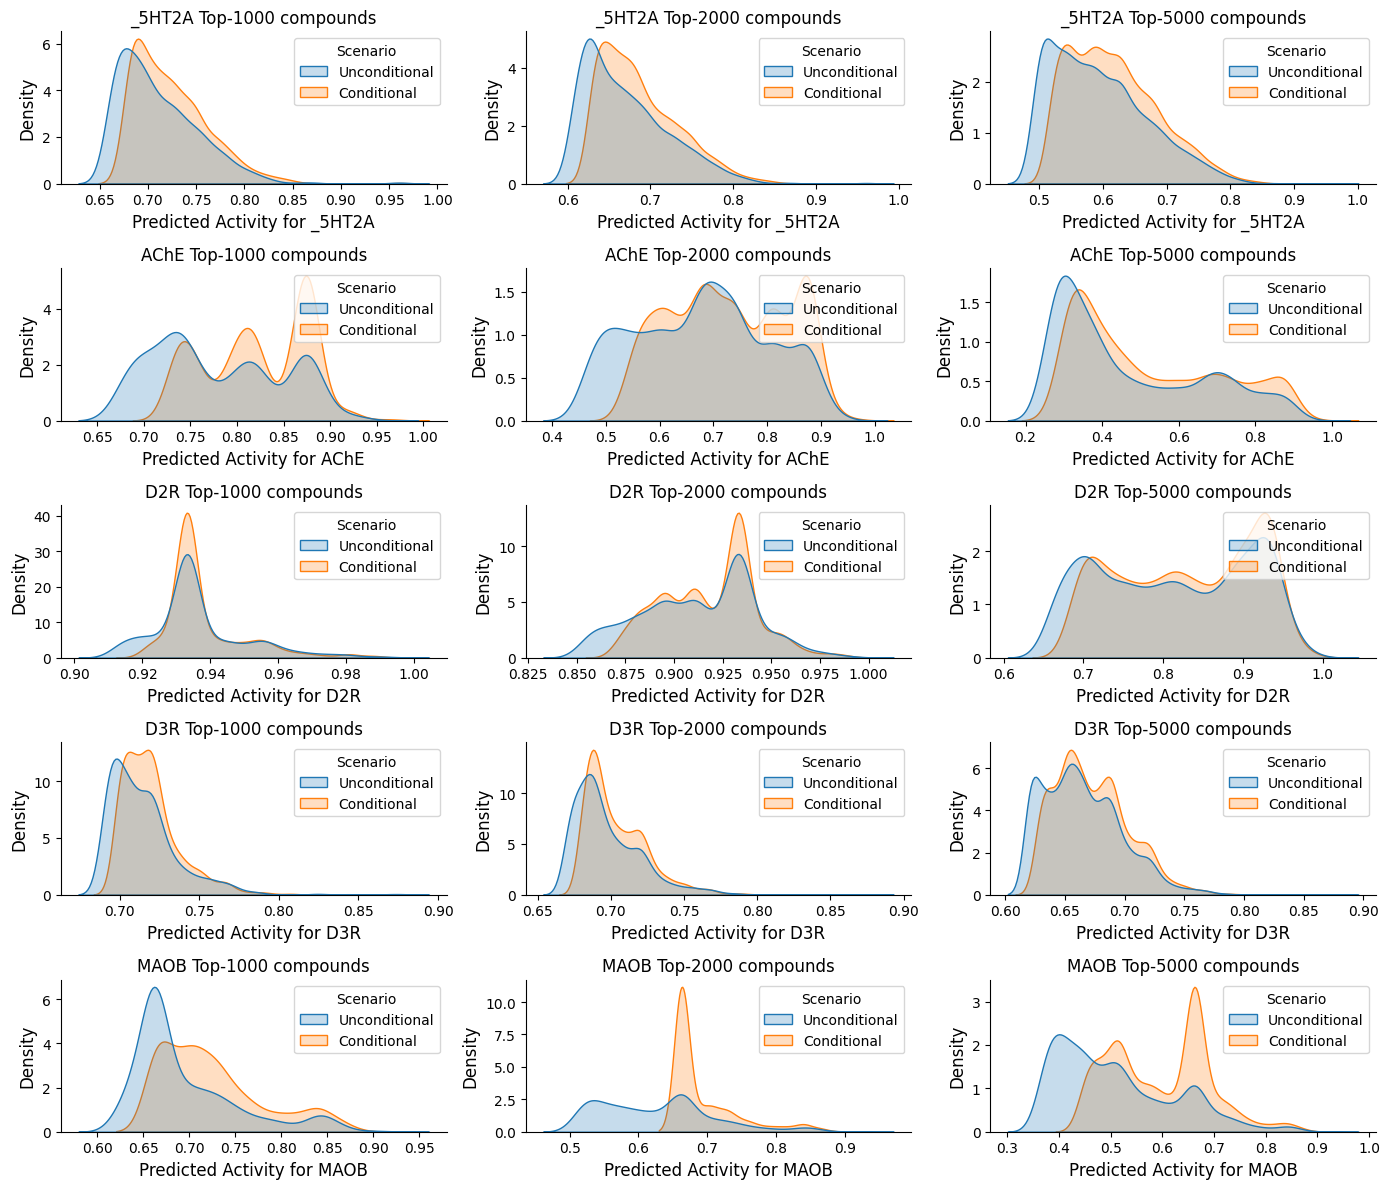

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

ACT_TYPE = "Activity" 
# ACT_TYPE = "pIC50"
# ACT_TYPE = "inhibition"

pal=list(sns.color_palette("tab10"))
fig, axes = plt.subplots(len(targets), len(num), figsize=(14, 12))

for i, name in enumerate(targets):
    for j, n in enumerate(num):
        activity_column = f"{name}_{ACT_TYPE}"
        unconditional = dataframes["Unconditional"][
            activity_column
        ].nlargest(n).to_frame().assign(Scenario="Unconditional")

        conditional = dataframes[name][
            activity_column
        ].nlargest(n).to_frame().assign(Scenario="Conditional")

        activities = pd.concat([unconditional, conditional]).reset_index()

        sns.kdeplot(data=activities, x=activity_column, bw_adjust=1, hue='Scenario',ax=axes[i, j], fill=True)
        # sns.histplot(data=activities, x=activity_column, hue='Scenario',ax=axes[i, j], fill=True)

        axes[i, j].set_title('{} Top-{} compounds'.format(name, n), fontsize=12)
        axes[i, j].spines['right'].set_visible(False)
        axes[i, j].spines['top'].set_visible(False)
        axes[i, j].set_ylabel("Density", fontsize=12)
        axes[i, j].set_xlabel(f"Predicted {ACT_TYPE} for {name}", fontsize=12)

    plt.tight_layout()

plt.show()

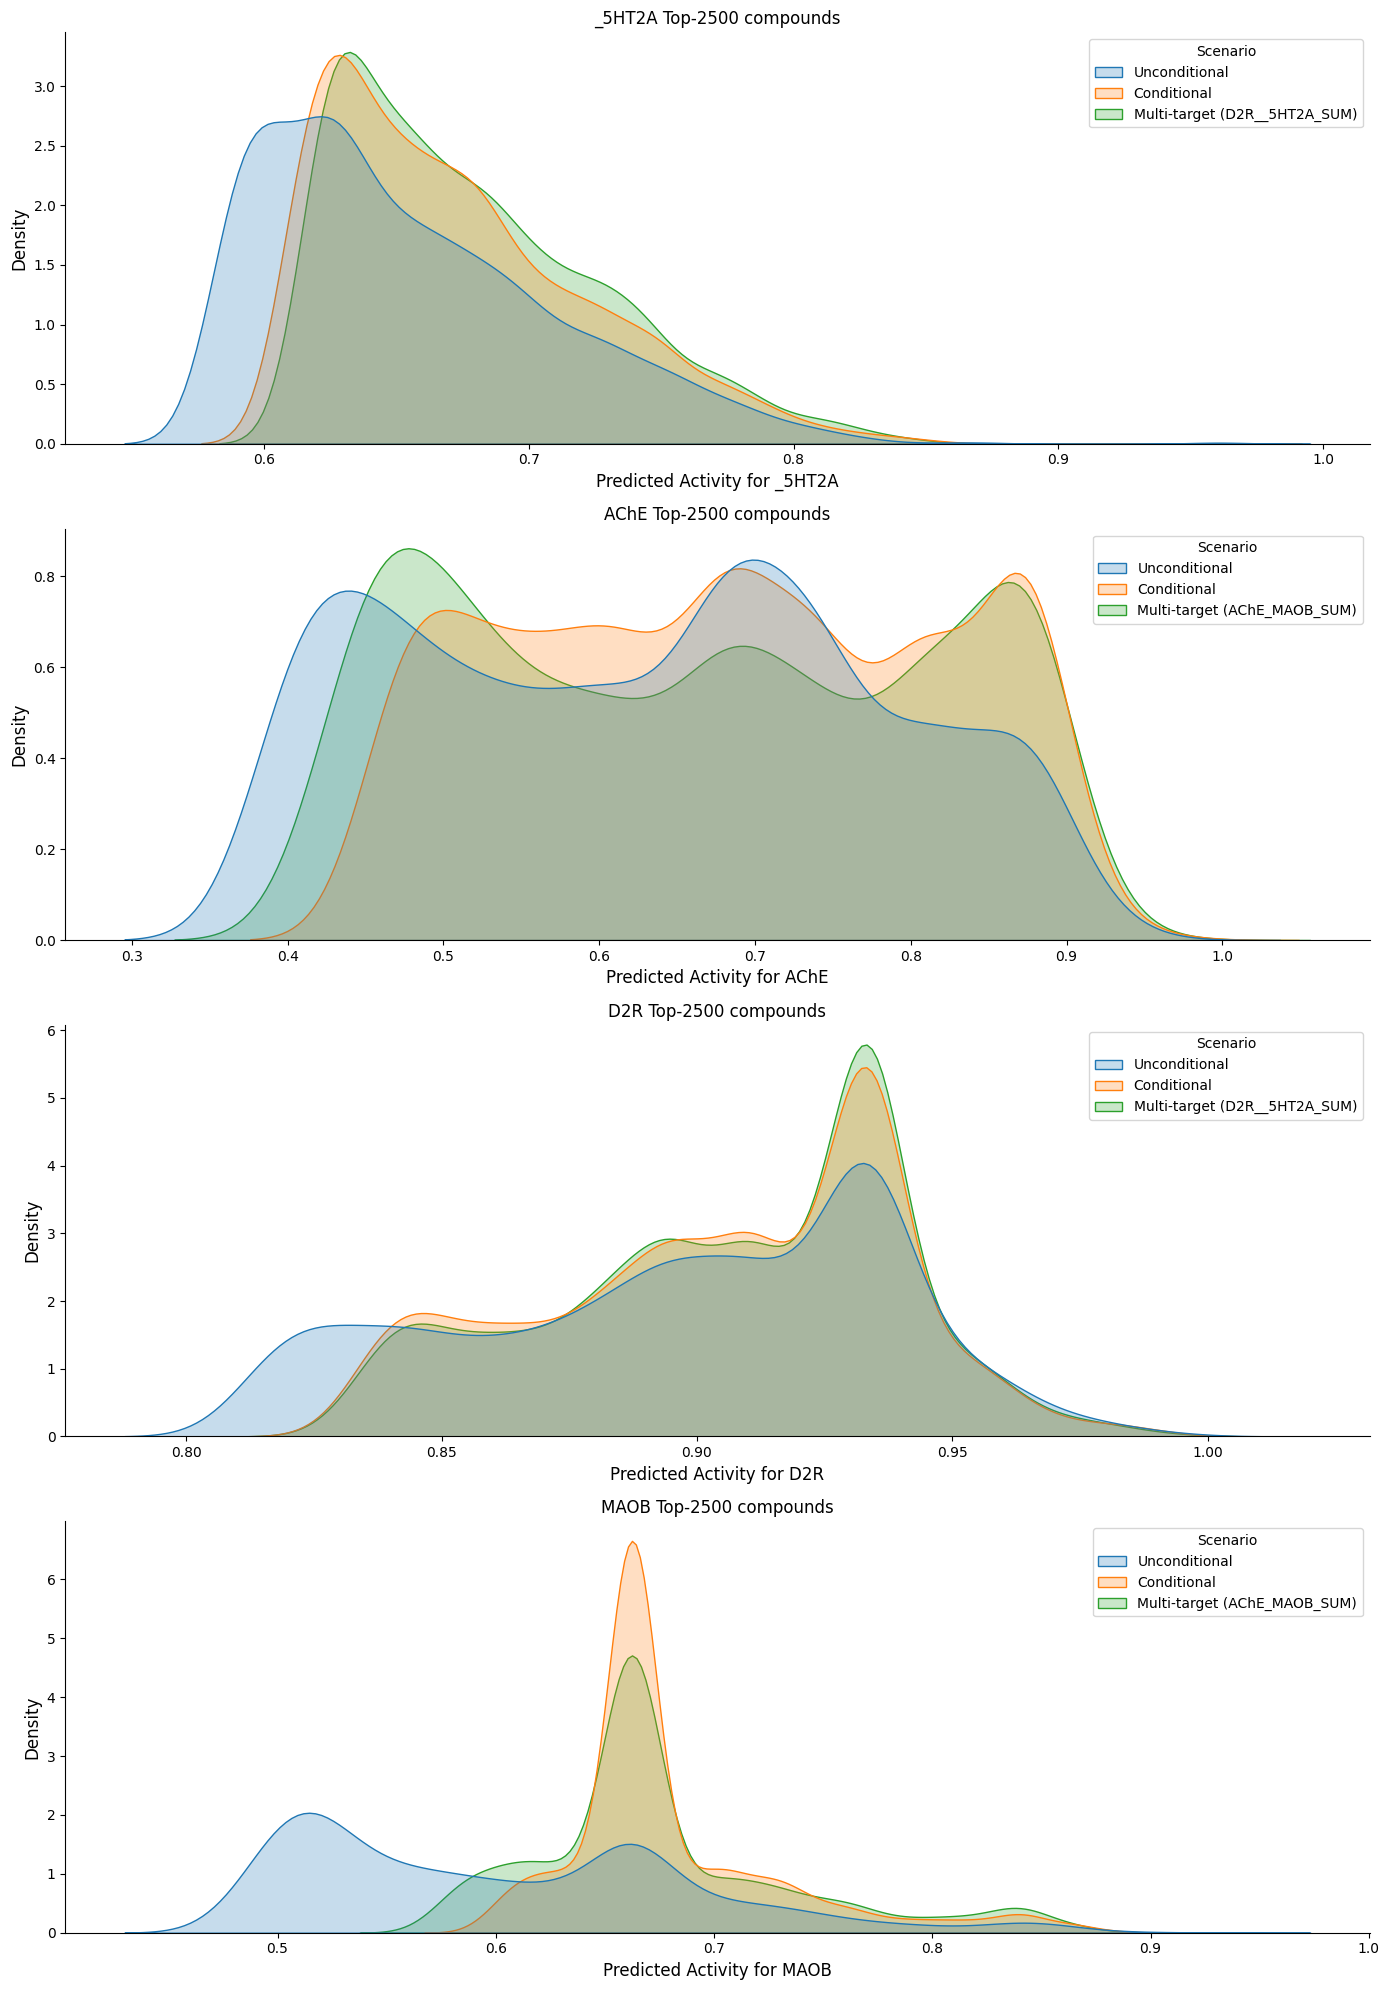

In [4]:
# Plot the multi-target distributions for the top 1000 compounds
agg = "SUM"

multi_targets = [
    f"AChE_MAOB_{agg}",
    f"D2R__5HT2A_{agg}",
    # f"D2R_D3R_{agg}"
]

# targets = ['_5HT2A', 'AChE', 'D2R', 'D3R', 'MAOB']
targets = ['_5HT2A', 'AChE', 'D2R', 'MAOB']
# targets =  ['AChE', 'MAOB']

fig, axes = plt.subplots(len(targets), 1, figsize=(14, 20))
n = 2500

for j, target in enumerate(targets):
    activity_column = f"{target}_{ACT_TYPE}"
    df_list = list()

    unconditional = dataframes["Unconditional"][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Unconditional")

    conditional = dataframes[target][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Conditional")

    df_list.append(unconditional)
    df_list.append(conditional)

    for mts in multi_targets:
        if target not in mts:
            continue
    
        multi_target = dataframes_mt[mts][
            activity_column
        ].nlargest(n).to_frame().assign(Scenario=f'Multi-target ({mts})')

        df_list.append(multi_target)

    activities = pd.concat(df_list).reset_index()

    sns.kdeplot(data=activities, x=activity_column, bw_adjust=1, hue='Scenario',ax=axes[j], fill=True)
    # sns.kdeplot(data=df, x="pred_pXC50", bw_adjust=1, hue='Scenario',ax=axes[j], fill=True)

    axes[j].set_title('{} Top-{} compounds'.format(target, n), fontsize=12)
    axes[j].spines['right'].set_visible(False)
    axes[j].spines['top'].set_visible(False)
    axes[j].set_ylabel("Density", fontsize=12)
    axes[j].set_xlabel(f"Predicted {ACT_TYPE} for {target}", fontsize=12)

plt.tight_layout()
plt.show()

In [5]:
# !pip install ptitprince

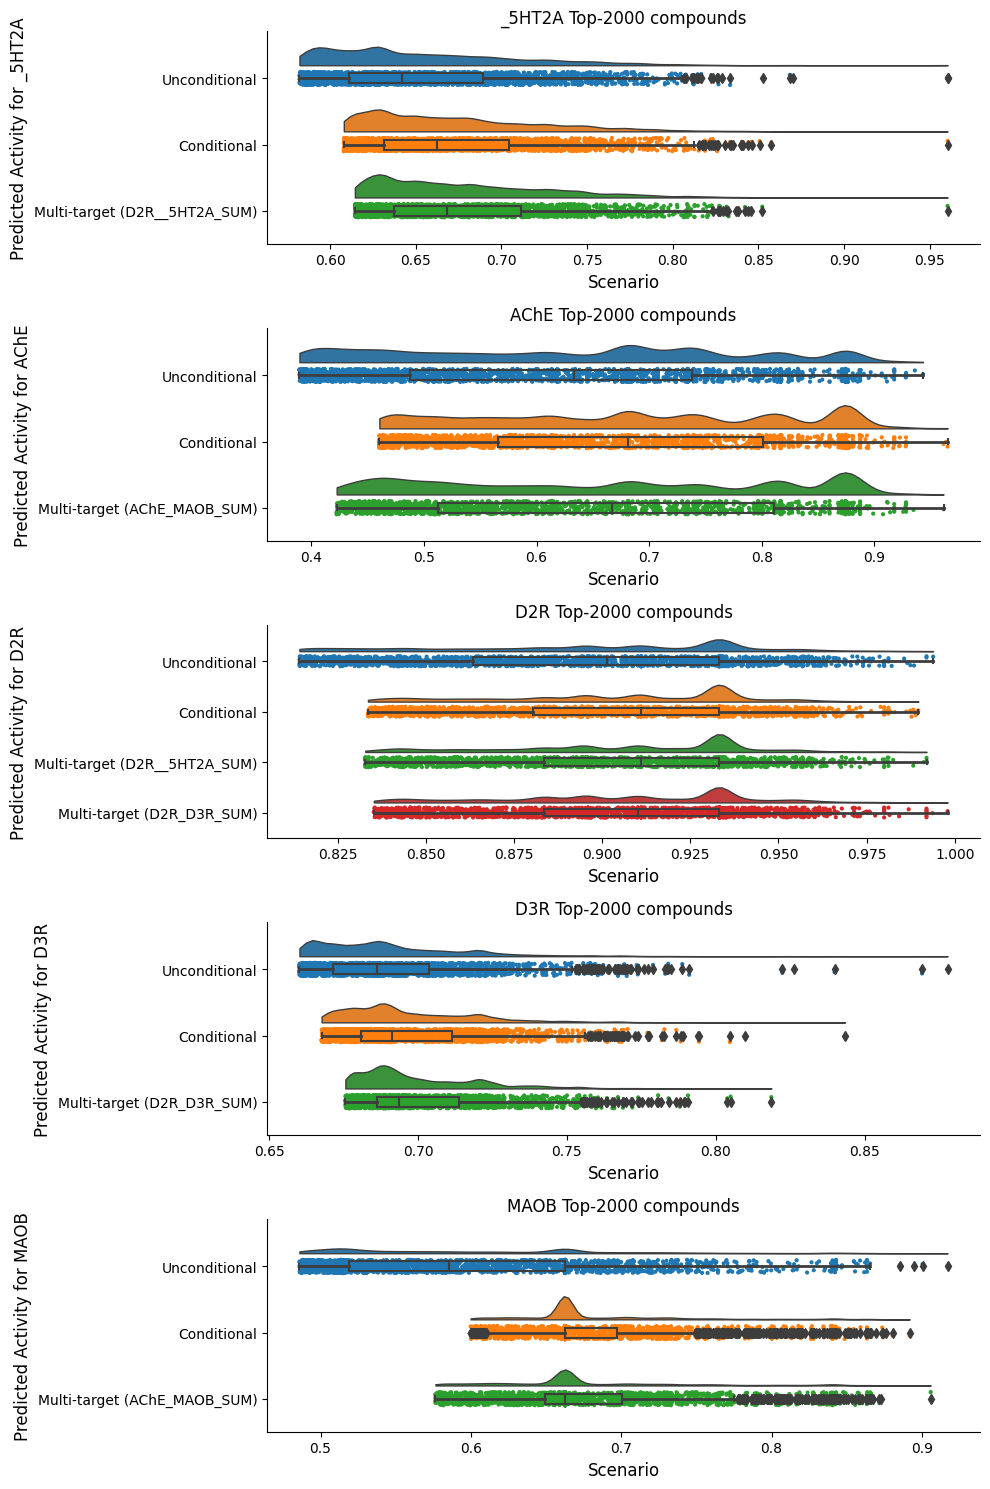

In [6]:
import ptitprince as pt

num = 2000
agg = "SUM"

multi_targets = [
    f"AChE_MAOB_{agg}",
    f"D2R__5HT2A_{agg}",
    f"D2R_D3R_{agg}"
]

targets = ['_5HT2A', 'AChE', 'D2R', 'D3R', 'MAOB']
# targets = ['_5HT2A', 'AChE', 'D2R', 'MAOB']
# targets =  ['AChE', 'MAOB']

fig, axes = plt.subplots(len(targets), figsize=(10, 15))

for i, target in enumerate(targets):
    activity_column = f"{target}_{ACT_TYPE}"
    df_list = list()

    unconditional = dataframes["Unconditional"][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Unconditional")

    conditional = dataframes[target][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Conditional")

    df_list.append(unconditional)
    df_list.append(conditional)

    for mts in multi_targets:
        if target not in mts:
            continue
    
        multi_target = dataframes_mt[mts][
            activity_column
        ].nlargest(n).to_frame().assign(Scenario=f'Multi-target ({mts})')

        df_list.append(multi_target)

    activities = pd.concat(df_list).reset_index()

    pt.RainCloud(data=activities, x='Scenario', y=activity_column, bw=.1, ax=axes[i], palette=pal, orient = "h")

    axes[i].set_title('{} Top-{} compounds'.format(target, num), fontsize=12)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['top'].set_visible(False)
    axes[i].set_ylabel(f"Predicted {ACT_TYPE} for {target}", fontsize=12)
    axes[i].set_xlabel("Scenario", fontsize=12)

plt.tight_layout()

plt.show()

In [7]:
for j, target in enumerate(targets):
    activity_column = f"{target}_{ACT_TYPE}"
    df_list = list()

    unconditional = dataframes["Unconditional"][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Unconditional")

    conditional = dataframes[target][
        activity_column
    ].nlargest(n).to_frame().assign(Scenario="Conditional")

    df_list.append(unconditional)
    df_list.append(conditional)

    for mts in multi_targets:
        if target not in mts:
            continue
    
        multi_target = dataframes_mt[mts][
            activity_column
        ].nlargest(n).to_frame().assign(Scenario=f'Multi-target ({mts})')

        df_list.append(multi_target)

    activities = pd.concat(df_list).reset_index()
    pivot = activities.pivot_table(index='Scenario', values=activity_column, aggfunc=[np.mean, np.std])
    format_str = "{:.2%}" if ACT_TYPE == "Activity" else "{:.2f}"

    # print(f"Target: {target}")
    display(pivot.style
                 .format(format_str)
                 .set_caption(f"Top-{n} {target} {ACT_TYPE} statistics")
                 .background_gradient(cmap='Blues', axis=0))

,mean,std
,_5HT2A_Activity,_5HT2A_Activity
Scenario,,
Conditional,67.32%,5.03%
Multi-target (D2R__5HT2A_SUM),67.90%,4.97%
Unconditional,65.46%,5.52%


,mean,std
,AChE_Activity,AChE_Activity
Scenario,,
Conditional,68.18%,13.44%
Multi-target (AChE_MAOB_SUM),65.89%,15.15%
Unconditional,62.64%,14.99%


,mean,std
,D2R_Activity,D2R_Activity
Scenario,,
Conditional,90.46%,3.46%
Multi-target (D2R_D3R_SUM),90.55%,3.41%
Multi-target (D2R__5HT2A_SUM),90.60%,3.41%
Unconditional,89.59%,4.17%


,mean,std
,D3R_Activity,D3R_Activity
Scenario,,
Conditional,69.76%,2.23%
Multi-target (D2R_D3R_SUM),70.08%,2.08%
Unconditional,69.08%,2.48%


,mean,std
,MAOB_Activity,MAOB_Activity
Scenario,,
Conditional,68.14%,5.20%
Multi-target (AChE_MAOB_SUM),67.67%,6.17%
Unconditional,60.19%,8.93%


### Assess mean target modulation

Unconditional
AChE
MAOB
AChE_MAOB_SUM
Unconditional
D2R
D3R
D2R_D3R_SUM
Unconditional
D2R
_5HT2A
D2R__5HT2A_SUM


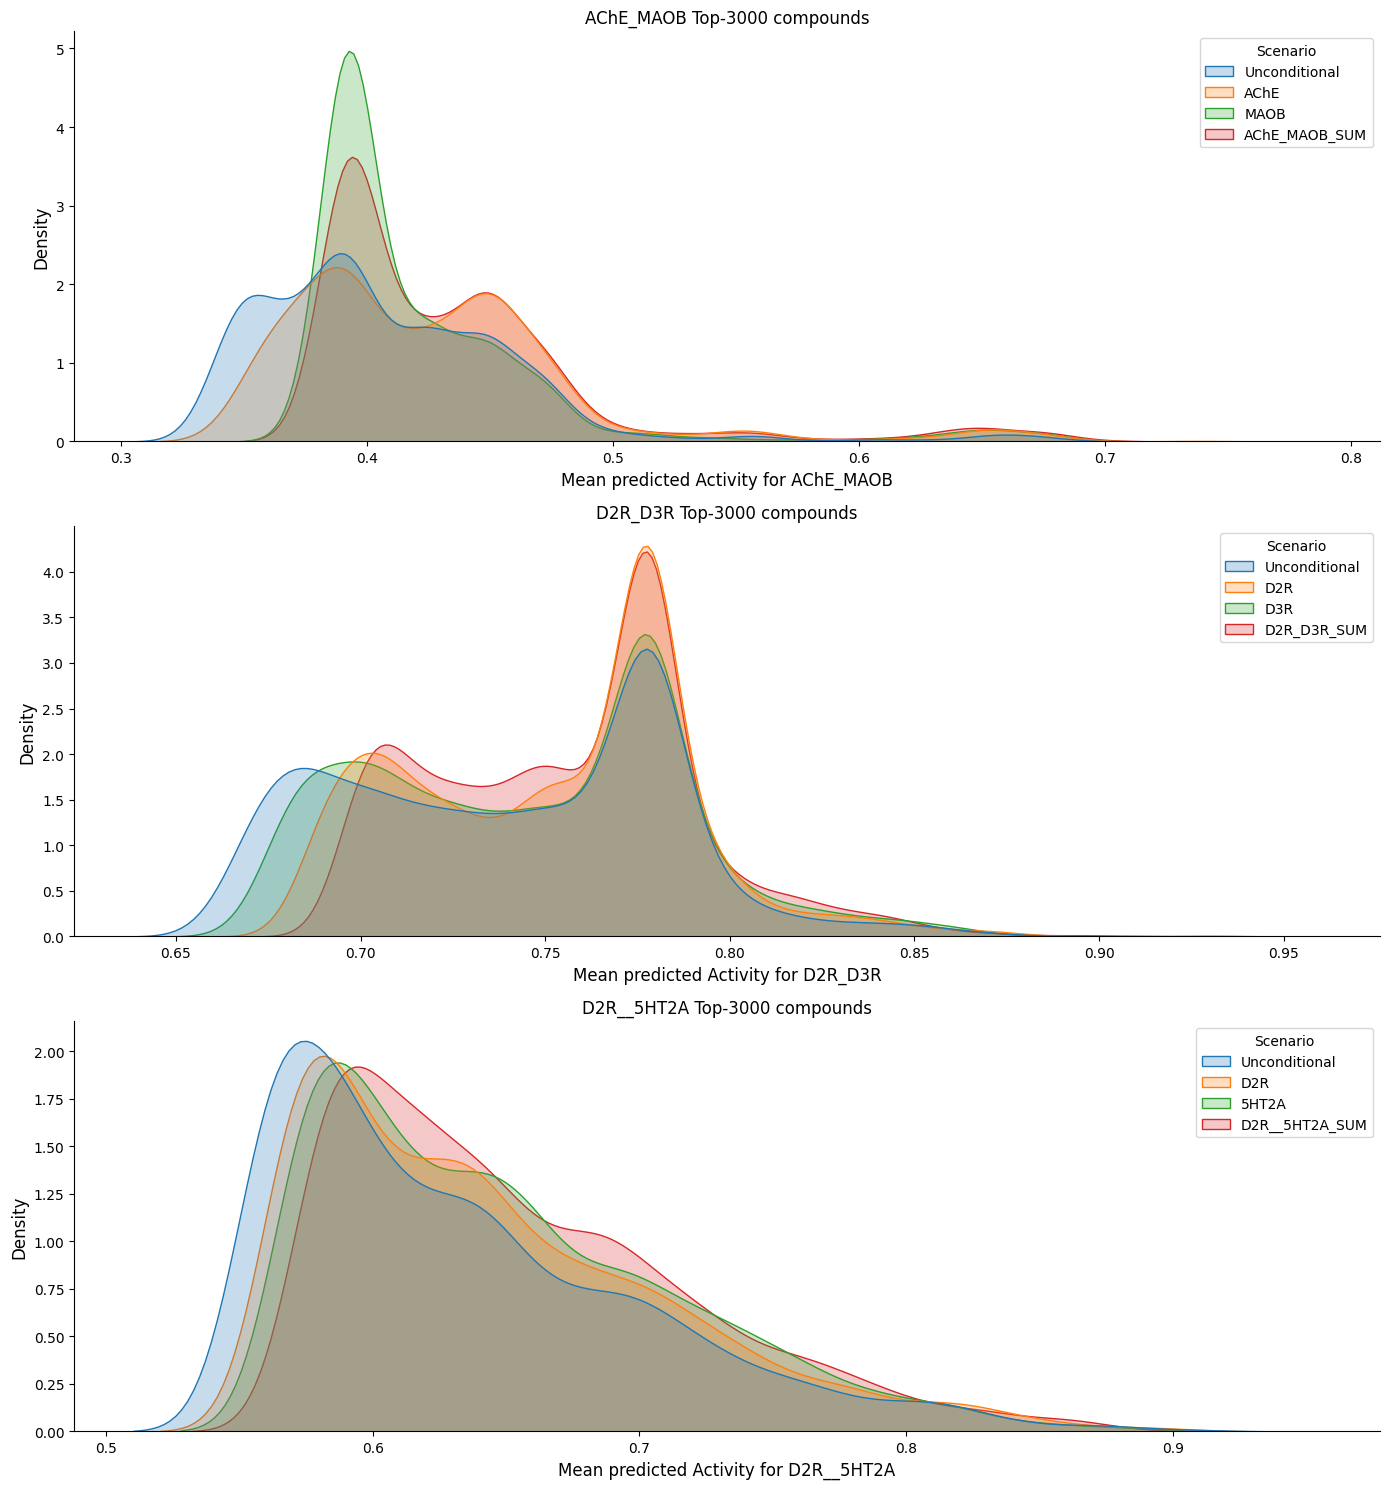

In [8]:
agg = "SUM"  # MEAN, MAX
ACT_TYPE = "Activity"  # pIC50, inhibition
# ACT_TYPE = "inhibition"  # pIC50, inhibition

multitarget_combination = {
    "AChE_MAOB": {
        "generated_molecules": ["Unconditional", "AChE", "MAOB", f"AChE_MAOB_{agg}"],
        # "generated_molecules": ["AChE", "MAOB", f"AChE_MAOB_{agg}"],
        "models": ["AChE", "MAOB"]
    },
    "D2R_D3R": {
        "generated_molecules": ["Unconditional", "D2R", "D3R", f"D2R_D3R_{agg}"],
        # "generated_molecules": [ "D2R", "D3R", f"D2R_D3R_{agg}"],
        "models": ["D2R", "D3R"]
    },
    "D2R__5HT2A": {
        "generated_molecules": ["Unconditional", "D2R", "_5HT2A", f"D2R__5HT2A_{agg}"],
        # "generated_molecules": [ "D2R", "_5HT2A", f"D2R__5HT2A_{agg}"],
        "models": ["D2R", "_5HT2A"]
    },
}

fig, axes = plt.subplots(len(multitarget_combination), 1, figsize=(14, 5 * len(multitarget_combination)))
n = 3000


for j, combination in enumerate(multitarget_combination):
    activity_column = f"{combination}_{ACT_TYPE}"
    df_list = list()
    # print(f"Combination: {activity_column}")

    gen_molecules = multitarget_combination[combination]["generated_molecules"]
    for gen_molecule in gen_molecules:
        print(gen_molecule)
        # df = pd.read_csv(f'../generated_molecules/predicted_activity/{gen_molecule}_MTDD.csv')
        df = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{gen_molecule}.csv')
        scenario = gen_molecule[1:] if gen_molecule.startswith("_") else gen_molecule
        df_filtered = df[activity_column].nlargest(n).to_frame().assign(Scenario=scenario)
        df_list.append(df_filtered)

    activities = pd.concat(df_list).reset_index()

    sns.kdeplot(data=activities, x=activity_column, bw_adjust=1, hue='Scenario',ax=axes[j], fill=True)
    # sns.kdeplot(data=df, x="pred_pXC50", bw_adjust=1, hue='Scenario',ax=axes[j], fill=True)

    axes[j].set_title('{} Top-{} compounds'.format(combination, n), fontsize=12)
    axes[j].spines['right'].set_visible(False)
    axes[j].spines['top'].set_visible(False)
    axes[j].set_ylabel("Density", fontsize=12)
    axes[j].set_xlabel(f"Mean predicted {ACT_TYPE} for {combination}", fontsize=12)

plt.tight_layout()
plt.show()

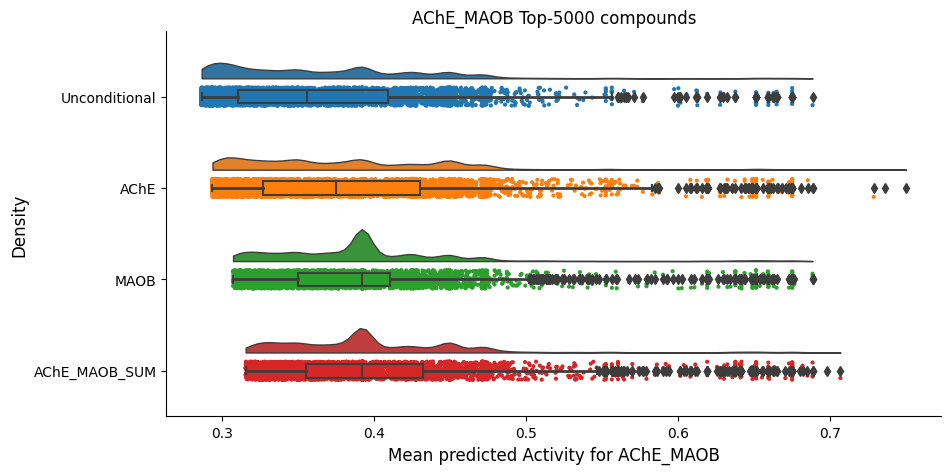

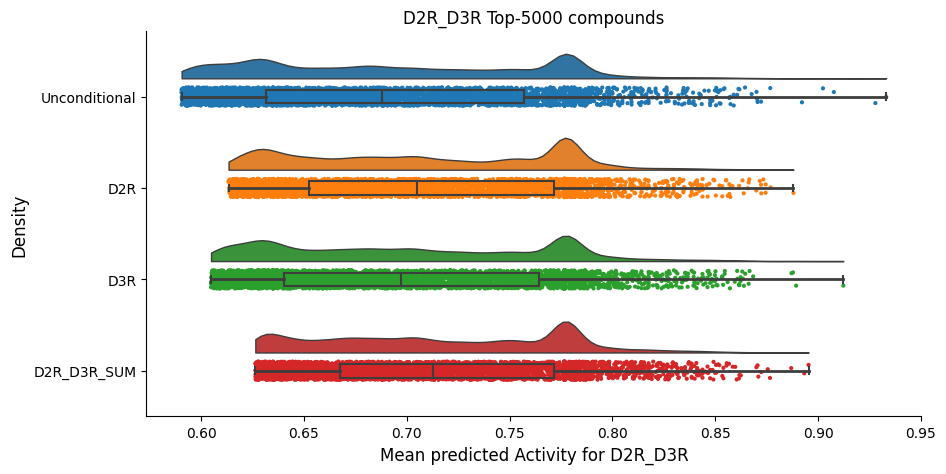

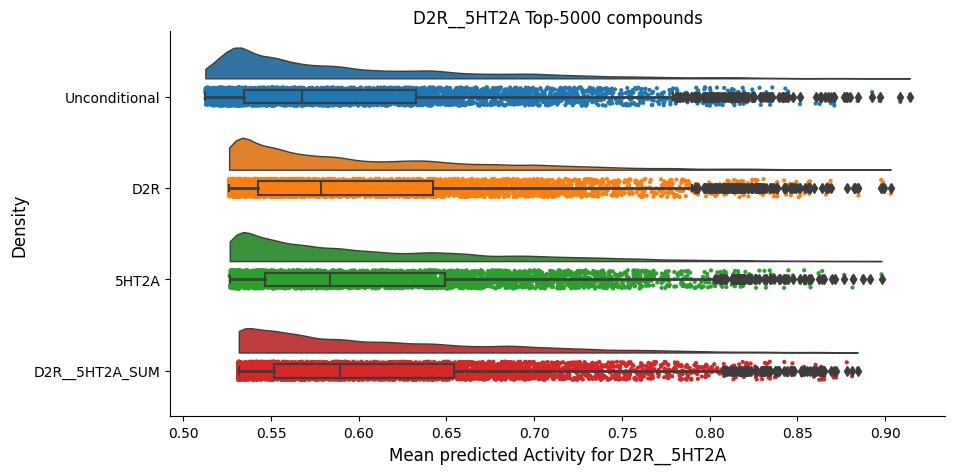

In [9]:
# fig, axes = plt.subplots(len(multitarget_combination), 1, figsize=(10, 5 * len(multitarget_combination)))
n = 5000

for j, (ax, combination) in enumerate(zip(axes, multitarget_combination)):
    activity_column = f"{combination}_{ACT_TYPE}"
    df_list = list()
    # print(f"Combination: {activity_column}")
    fig, ax = plt.subplots(1, 1, figsize=(10, 5 * 1))


    gen_molecules = multitarget_combination[combination]["generated_molecules"]
    for gen_molecule in gen_molecules:
        # print(gen_molecule)
        # df = pd.read_csv(f'../generated_molecules/predicted_activity/{gen_molecule}_MTDD.csv')
        df = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{gen_molecule}.csv')
        scenario = gen_molecule[1:] if gen_molecule.startswith("_") else gen_molecule
        df_filtered = df[activity_column].nlargest(n).to_frame().assign(Scenario=scenario)
        df_list.append(df_filtered)

    activities = pd.concat(df_list).reset_index()

    pt.RainCloud(data=activities, x='Scenario', y=activity_column, bw=.1, ax=ax, palette=pal, orient="h")
    # sns.kdeplot(data=df, x="pred_pXC50", bw_adjust=1, hue='Scenario',ax=axes[j], fill=True)

    ax.set_title('{} Top-{} compounds'.format(combination, n), fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel("Density", fontsize=12)
    ax.set_xlabel(f"Mean predicted {ACT_TYPE} for {combination}", fontsize=12)

    plt.show()

# plt.tight_layout()
# plt.show()

In [10]:
for j, combination in enumerate(multitarget_combination):
    activity_column = f"{combination}_{ACT_TYPE}"
    df_list = list()

    gen_molecules = multitarget_combination[combination]["generated_molecules"]
    for gen_molecule in gen_molecules:
        df = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{gen_molecule}.csv')
        scenario = gen_molecule[1:] if gen_molecule.startswith("_") else gen_molecule
        df_filtered = df[activity_column].nlargest(n).to_frame().assign(Scenario=scenario)
        df_list.append(df_filtered)

    activities = pd.concat(df_list).reset_index()
    pivot = activities.pivot_table(index='Scenario', values=activity_column, aggfunc=[np.mean, np.std])
    pivot = pivot.rename(columns={'mean': 'Mean', 'std': 'Std Deviation'})
    pivot = pivot.sort_values(by=('Mean', activity_column), ascending=False)

    format_str = "{:.2%}" if ACT_TYPE == "Activity" else "{:.2f}"
    # print(f"Combination: {combination}")
    display(pivot.style
                 .format(format_str)
                 .set_caption(f"Top-{n} {combination} {ACT_TYPE} statistics")
                 .background_gradient(cmap='Blues', axis=0))

,Mean,Std Deviation
,AChE_MAOB_Activity,AChE_MAOB_Activity
Scenario,,
AChE_MAOB_SUM,40.08%,6.35%
MAOB,39.07%,5.92%
AChE,38.44%,7.15%
Unconditional,36.79%,6.58%


,Mean,Std Deviation
,D2R_D3R_Activity,D2R_D3R_Activity
Scenario,,
D2R_D3R_SUM,71.66%,5.72%
D2R,70.97%,6.11%
D3R,70.19%,6.40%
Unconditional,69.43%,6.69%


,Mean,Std Deviation
,D2R__5HT2A_Activity,D2R__5HT2A_Activity
Scenario,,
D2R__5HT2A_SUM,61.11%,7.26%
5HT2A,60.56%,7.25%
D2R,60.20%,7.28%
Unconditional,59.29%,7.23%


In [11]:
# ANOVA test
import statsmodels.api as sm
from statsmodels.formula.api import ols


for j, combination in enumerate(multitarget_combination):
    # print()
    activity_column = f"{combination}_{ACT_TYPE}"
    df_list = list()

    gen_molecules = multitarget_combination[combination]["generated_molecules"]
    for gen_molecule in gen_molecules:
        df = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{gen_molecule}.csv')
        scenario = gen_molecule[1:] if gen_molecule.startswith("_") else gen_molecule
        df_filtered = df[activity_column].nlargest(n).to_frame().assign(Scenario=scenario)
        df_list.append(df_filtered)

    activities = pd.concat(df_list).reset_index()
    model = ols(f'{activity_column} ~ C(Scenario)', data=activities).fit()

    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"Combination: {combination}")
    display(anova_table)

    # Check if the p-value is significant
    p_value = anova_table['PR(>F)'][0]
    print(f"p-value: {p_value:.8f}")

    if p_value < 0.05:
        print("Significant: Reject the null hypothesis")
    else:
        print("Not significant: Fail to reject the null hypothesis")

    # Check the effect size
    eta_squared = anova_table['sum_sq'][0] / (anova_table['sum_sq'][0] + anova_table['sum_sq'][1])
    print(f"Effect size: {eta_squared:.8f}")

    # Check the power
    power = 0.8

    # Perform a power analysis
    from statsmodels.stats.power import FTestAnovaPower

    f_test = FTestAnovaPower()
    sample_size = f_test.solve_power(effect_size=eta_squared, alpha=0.05, power=power)

    print(f"Sample size: {sample_size:.2f}")

    # Perform a post-hoc test
    from statsmodels.stats.multicomp import pairwise_tukeyhsd

    unique_scenarios = activities['Scenario'].unique()

    posthoc = pairwise_tukeyhsd(
        activities[activity_column], activities['Scenario']
    )

    print(f"Combination: {combination}")
    print(posthoc)

Combination: AChE_MAOB


,sum_sq,df,F,PR(>F)
C(Scenario),2.848619,3.0,223.730846,8.994142e-143
Residual,84.865356,19996.0,NaN,NaN


p-value: 0.00000000
Significant: Reject the null hypothesis
Effect size: 0.03247623
Sample size: 7443.66
Combination: AChE_MAOB
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
    group1        group2    meandiff p-adj  lower   upper  reject
-----------------------------------------------------------------
         AChE AChE_MAOB_SUM   0.0164  -0.0   0.013  0.0197   True
         AChE          MAOB   0.0063   0.0  0.0029  0.0096   True
         AChE Unconditional  -0.0165  -0.0 -0.0198 -0.0131   True
AChE_MAOB_SUM          MAOB  -0.0101  -0.0 -0.0135 -0.0068   True
AChE_MAOB_SUM Unconditional  -0.0329  -0.0 -0.0362 -0.0295   True
         MAOB Unconditional  -0.0227  -0.0 -0.0261 -0.0194   True
-----------------------------------------------------------------
Combination: D2R_D3R


,sum_sq,df,F,PR(>F)
C(Scenario),1.393120,3.0,119.248417,1.511608e-76
Residual,77.867756,19996.0,NaN,NaN


p-value: 0.00000000
Significant: Reject the null hypothesis
Effect size: 0.01757638
Sample size: 25408.51
Combination: D2R_D3R
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1       group2    meandiff p-adj  lower   upper  reject
---------------------------------------------------------------
        D2R   D2R_D3R_SUM   0.0069   0.0  0.0037  0.0101   True
        D2R           D3R  -0.0077   0.0  -0.011 -0.0045   True
        D2R Unconditional  -0.0154  -0.0 -0.0186 -0.0122   True
D2R_D3R_SUM           D3R  -0.0147  -0.0 -0.0179 -0.0114   True
D2R_D3R_SUM Unconditional  -0.0223  -0.0 -0.0255 -0.0191   True
        D3R Unconditional  -0.0076   0.0 -0.0108 -0.0044   True
---------------------------------------------------------------
Combination: D2R__5HT2A


,sum_sq,df,F,PR(>F)
C(Scenario),0.873316,3.0,55.307734,1.353961e-35
Residual,105.246450,19996.0,NaN,NaN


p-value: 0.00000000
Significant: Reject the null hypothesis
Effect size: 0.00822953
Sample size: 115894.38
Combination: D2R__5HT2A
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------
         5HT2A            D2R  -0.0036 0.0654 -0.0073  0.0001  False
         5HT2A D2R__5HT2A_SUM   0.0055 0.0009  0.0017  0.0092   True
         5HT2A  Unconditional  -0.0127   -0.0 -0.0164  -0.009   True
           D2R D2R__5HT2A_SUM    0.009    0.0  0.0053  0.0128   True
           D2R  Unconditional  -0.0091    0.0 -0.0128 -0.0054   True
D2R__5HT2A_SUM  Unconditional  -0.0182   -0.0 -0.0219 -0.0144   True
--------------------------------------------------------------------


### Data exploration and visualization

In [12]:
import sys
import torch
from collections import namedtuple

sys.path.append('../cMolGPT/')

from model_auto import Seq2SeqTransformer
from utils import read_delimited_file, read_csv_file
import vocabulary as mv

mol_list0_train = list(read_delimited_file('../data/train.smi'))
mol_list0_test = list(read_delimited_file('../data/test.smi'))

mol_list1, target_list = zip(*read_csv_file('../data/chembl_active_compounds.smi', num_fields=2))
mol_list = mol_list0_train
mol_list.extend(mol_list0_test) 
mol_list.extend(mol_list1)
vocabulary = mv.create_vocabulary(smiles_list=mol_list, tokenizer=mv.SMILESTokenizer())

BATCH_SIZE = 512
SRC_VOCAB_SIZE = len(vocabulary)
TGT_VOCAB_SIZE = len(vocabulary)

EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512

NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = DEVICE

args = namedtuple('args',['nhead'])(nhead=NHEAD)

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, 
                                EMB_SIZE, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE,
                                FFN_HID_DIM, args=args, emb_input_size=7)
transformer = transformer.to(device)
transformer.load_state_dict(torch.load('../models_cMolGPT/finetune.h5'))

<All keys matched successfully>

In [13]:
targets_to_idx = {
    "AChE": 1,
    "D2R": 2,
    # "D3R": 3,
    "_5HT2A": 4,
    "MAOB": 5,
}

target_to_key = {
    "AChE": torch.tensor([1]).to(device),
    "D2R": torch.tensor([2]).to(device),
    # "D3R": torch.tensor([3]).to(device),
    "_5HT2A": torch.tensor([4]).to(device),
    "MAOB": torch.tensor([5]).to(device),
}

target_embedding = dict()

for target in target_to_key:
    embedding = transformer.emb(target_to_key[target])
    target_embedding[target] = embedding

target_embedding["AChE"].shape

torch.Size([1, 512])

In [14]:
# compute the cosine similarity between the target embeddings
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

similarity = dict()

for target1 in target_embedding:
    for target2 in target_embedding:
        similarity[f"{target1}_{target2}"] = cos(target_embedding[target1], target_embedding[target2])

# similarity

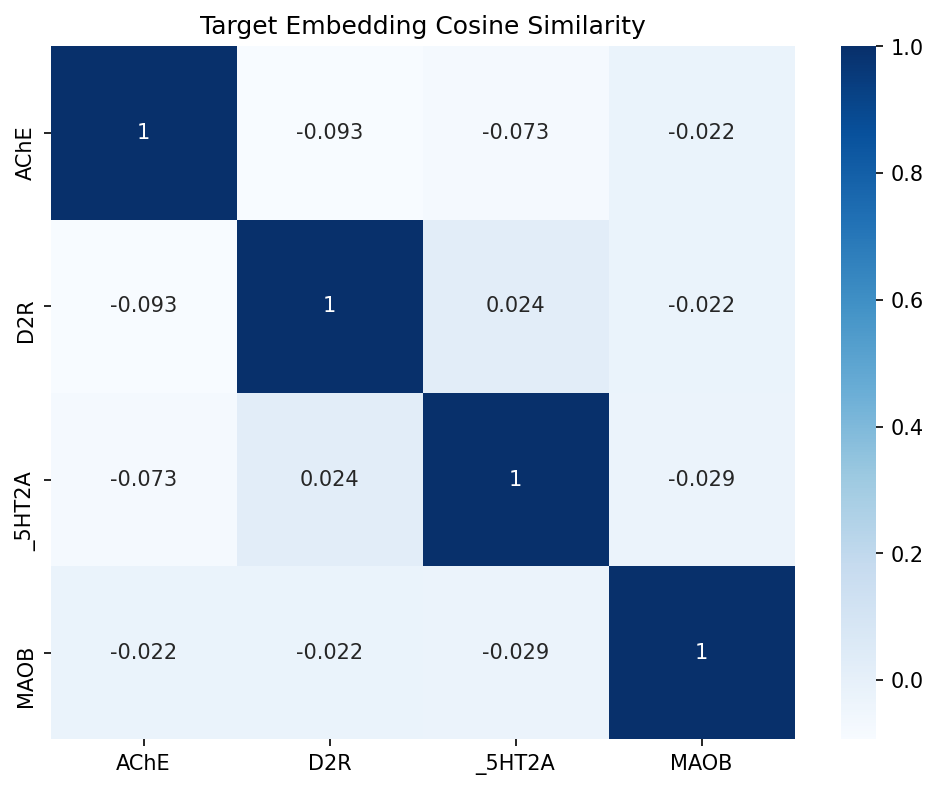

In [15]:
# plot the similarity matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

similarity_matrix = np.zeros((len(target_embedding), len(target_embedding)))

for i, target1 in enumerate(target_embedding):
    for j, target2 in enumerate(target_embedding):
        similarity_matrix[i, j] = similarity[f"{target1}_{target2}"].item()

plt.figure(figsize=(8, 6), dpi=150)

sns.heatmap(
    similarity_matrix, 
    annot=True, cmap='Blues',
    xticklabels=target_embedding.keys(), 
    yticklabels=target_embedding.keys()
)

plt.title('Target Embedding Cosine Similarity')

plt.show()

In [16]:
# egfr_sequence = """MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEV
# VLGNLEITYVQRNYDLSFLKTIQEVAGYVLIALNTVERIPLENLQIIRGNMYYENSYALA
# VLSNYDANKTGLKELPMRNLQEILHGAVRFSNNPALCNVESIQWRDIVSSDFLSNMSMDF
# QNHLGSCQKCDPSCPNGSCWGAGEENCQKLTKIICAQQCSGRCRGKSPSDCCHNQCAAGC
# TGPRESDCLVCRKFRDEATCKDTCPPLMLYNPTTYQMDVNPEGKYSFGATCVKKCPRNYV
# VTDHGSCVRACGADSYEMEEDGVRKCKKCEGPCRKVCNGIGIGEFKDSLSINATNIKHFK
# NCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAF
# ENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKL
# FGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCVSCRNVSRGRECVDKCN
# LLEGEPREFVENSECIQCHPECLPQAMNITCTGRGPDNCIQCAHYIDGPHCVKTCPAGVM
# GENNTLVWKYADAGHVCHLCHPNCTYGCTGPGLEGCPTNGPKIPSIATGMVGALLLLLVV
# ALGIGLFMRRRHIVRKRTLRRLLQERELVEPLTPSGEAPNQALLRILKETEFKKIKVLGS
# GAFGTVYKGLWIPEGEKVKIPVAIKELREATSPKANKEILDEAYVMASVDNPHVCRLLGI
# CLTSTVQLITQLMPFGCLLDYVREHKDNIGSQYLLNWCVQIAKGMNYLEDRRLVHRDLAA
# RNVLVKTPQHVKITDFGLAKLLGAEEKEYHAEGGKVPIKWMALESILHRIYTHQSDVWSY
# GVTVWELMTFGSKPYDGIPASEISSILEKGERLPQPPICTIDVYMIMVKCWMIDADSRPK
# FRELIIEFSKMARDPQRYLVIQGDERMHLPSPTDSNFYRALMDEEDMDDVVDADEYLIPQ
# QGFFSSPSTSRTPLLSSLSATSNNSTVACIDRNGLQSCPIKEDSFLQRYSSDPTGALTED
# SIDDTFLPVPEYINQSVPKRPAGSVQNPVYHNQPLNPAPSRDPHYQDPHSTAVGNPEYLN
# TVQPTCVNSTFDSPAHWAQKGSHQISLDNPDYQQDFFPKEAKPNGIFKGSTAENAEYLRV
# APQSSEFIGA"""

# htr1a_sequence = """MDVLSPGQGNNTTSPPAPFETGGNTTGISDVTVSYQVITSLLLGTLIFCAVLGNACVVAA
# IALERSLQNVANYLIGSLAVTDLMVSVLVLPMAALYQVLNKWTLGQVTCDLFIALDVLCC
# TSSILHLCAIALDRYWAITDPIDYVNKRTPRRAAALISLTWLIGFLISIPPMLGWRTPED
# RSDPDACTISKDHGYTIYSTFGAFYIPLLLMLVLYGRIFRAARFRIRKTVKKVEKTGADT
# RHGASPAPQPKKSVNGESGSRNWRLGVESKAGGALCANGAVRQGDDGAALEVIEVHRVGN
# SKEHLPLPSEAGPTPCAPASFERKNERNAEAKRKMALARERKTVKTLGIIMGTFILCWLP
# FFIVALVLPFCESSCHMPTLLGAIINWLGYSNSLLNPVIYAYFNKDFQNAFKKIIKCKFC
# RQ"""

# s1pr1_sequence = """MGPTSVPLVKAHRSSVSDYVNYDIIVRHYNYTGKLNISADKENSIKLTSVVFILICCFII
# LENIFVLLTIWKTKKFHRPMYYFIGNLALSDLLAGVAYTANLLLSGATTYKLTPAQWFLR
# EGSMFVALSASVFSLLAIAIERYITMLKMKLHNGSNNFRLFLLISACWVISLILGGLPIM
# GWNCISALSSCSTVLPLYHKHYILFCTTVFTLLLLSIVILYCRIYSLVRTRSRRLTFRKN
# ISKASRSSEKSLALLKTVIIVLSVFIACWAPLFILLLLDVGCKVKTCDILFRAEYFLVLA
# VLNSGTNPIIYTLTNKEMRRAFIRIMSCCKCPSGDSAGKFKRPIIAGMEFSRSKSDNSSH
# PQKDEGDNPETIMSSGNVNSSS"""

In [17]:
# from Bio.Seq import Seq
# from Bio.Align import PairwiseAligner

# egfr_seq = Seq(egfr_sequence.replace('\n', ''))
# htr1a_seq = Seq(htr1a_sequence.replace('\n', ''))
# s1pr1_seq = Seq(s1pr1_sequence.replace('\n', ''))

# targets_seq = {
#     "EGFR": egfr_seq,
#     "HTR1A": htr1a_seq,
#     "S1PR1": s1pr1_seq
# }

# egfr_seq

In [18]:
# aligner = PairwiseAligner()

# for target1 in targets_seq:
#     for target2 in targets_seq:
#         alignments = aligner.align(targets_seq[target1], targets_seq[target2])
#         best_alignment = alignments[0]

#         print(f"Alignment between {target1} and {target2}")
#         # print(best_alignment)

#         # Calculate sequence similarity as the fraction of identical residues
#         similarity = best_alignment.score / len(targets_seq[target1])

#         print(f"Similarity: {similarity:.2f}")

# # plot the similarity matrix
# similarity_matrix = np.zeros((3, 3))

# for i, target1 in enumerate(targets_seq):
#     for j, target2 in enumerate(targets_seq):
#         alignments = aligner.align(targets_seq[target1], targets_seq[target2])
#         best_alignment = alignments[0]

#         similarity_matrix[i, j] = best_alignment.score / len(targets_seq[target1])

# plt.figure(figsize=(8, 6), dpi=150)

# sns.heatmap(
#     similarity_matrix, 
#     annot=True, cmap='Blues',
#     xticklabels=targets_seq.keys(), 
#     yticklabels=targets_seq.keys()
# )

# plt.title('Target Protein Sequence Similarity')

# plt.show()

In [19]:
# from rdkit import RDLogger

# RDLogger.DisableLog('rdApp.*')

# import lightgbm as lgb
# from process_training_data import get_fp

# # load qsar models for each target
# targets = ["EGFR", "HTR1A", "S1PR1"]

# model = dict()

# for target in targets:
#     model[target] = lgb.Booster(model_file=f'./model/{target}.txt')

# # load active molecules dataset for each target
# active_molecules = dict()

# for target in targets:
#     X = np.load('npy/{}_X.npy'.format(target))
#     y = np.load('npy/{}_y.npy'.format(target))

#     print(X.shape, y.shape)

#     res = pd.DataFrame(X, columns=list(range(len(X[0]))))
#     res['activity'] = y

#     # res_active = res[res['activity'] >= 6.5]

#     active_molecules[target] = res

# # for each model, predict the activity of the active molecules datasets
# predicted_activities = dict()

# for target_model in targets:
#     predicted_activities[target_model] = dict()

#     for target_dataset in targets:
#         X = active_molecules[target_dataset].drop(columns=['activity']).values
#         y = active_molecules[target_dataset]['activity'].values

#         predicted_activities[target_model][target_dataset] = model[target_model].predict(X)

# # plot a scatter plot of the predicted activities for each target
# # each row is a target model, each column is a target dataset
# # the x axis is the predicted activity of the target model, the y axis is the predicted activity of the target dataset
# fig, axes = plt.subplots(3, 3, figsize=(14, 12))

# for i, target_model in enumerate(targets):
#     for j, target_dataset in enumerate(targets):
#         axes[i, j].scatter(
#             predicted_activities[target_model][target_dataset], 
#             active_molecules[target_dataset]['activity'], 
#             # predicted_activities[target_dataset][target_dataset],
#             alpha=0.3,
#             color=pal[i]
#         )

#         axes[i, j].set_title(f'{target_model} model vs {target_dataset} dataset')
#         axes[i, j].set_xlabel(f'{target_model} predicted activity (pXC50)')
#         axes[i, j].set_ylabel(f'{target_dataset} true activity (pXC50)')

#         # calculate the correlation coefficient
#         correlation = np.corrcoef(
#             predicted_activities[target_model][target_dataset], 
#             active_molecules[target_dataset]['activity']
#         )[0, 1]

#         axes[i, j].text(0.5, 0.9, f'Correlation: {correlation:.2f}', 
#                         horizontalalignment='center',
#                         verticalalignment='center',
#                         transform=axes[i, j].transAxes)


# plt.tight_layout()
# plt.show()

In [20]:
active_molecules_smiles = dict()
smiles_target = pd.read_csv("../data/chembl_active_compounds.smi", sep="\t", names=["SMILES", "target"])

targets_to_idx = {
    "AChE": 1,
    "D2R": 2,
    "D3R": 3,
    "_5HT2A": 4,
    "MAOB": 5,
}

for target in targets_to_idx:
    _id = targets_to_idx[target]
    smiles_target_id = smiles_target[smiles_target["target"] == _id]
    active_molecules_smiles[target] = smiles_target_id.sample(150)

active_molecules_smiles

{'AChE':                                                 SMILES  target
 281  CO[C@H]1C[C@H]2C(=C[C@@H]1OC(=O)c1cc([N+](=O)[...       1
 208            COc1cccc2c1C=[N+](c1ccc(I)cc1)CC2.[Br-]       1
 29   CC[N+](C)(CC)CCC[n+]1c(-c2ccccc2)c2cc(N)ccc2c2...       1
 47            Nc1nc(C(F)(F)F)cc2c1[nH]c(=O)n2Cc1ccccc1       1
 128  CCN(CCCCCCn1c(=O)c(=O)n(CCCCCCN(CC)Cc2ccccc2OC...       1
 ..                                                 ...     ...
 240    O=C(c1ccccc1)c1c(C2CCN(Cc3ccccc3)CC2)oc2ccccc12       1
 39   CC1=CC2Cc3nc4cc(Cl)ccc4c(NCCCCCCCCCCNc4c5c(nc6...       1
 142  COc1cc2c(cc1OC)C(=O)C(CC1CCN(CCNc3c4c(nc5cc(Cl...       1
 202    COc1ccc2c3c1O[C@H]1C[C@@H](O)C=C[C@@]31CCN(C)C2       1
 41   CC[N+](C)(CC)CCC[n+]1c(-c2ccccc2)c2cc(N)ccc2c2...       1
 
 [150 rows x 2 columns],
 'D2R':                                                 SMILES  target
 364       COc1cc2c(cc1O)[C@@H]1Cc3sc(CC(C)Cl)cc3CN1CC2       2
 524  O=C1NC2(CCc3ccccc32)C(=O)N1CCCCN1CCN(c2cccc(Cl...       

In [21]:
# import tanimoto bulk similarity
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import MolFromSmiles

# for each target, calculate the tanimoto similarity between the active molecules datasets
tanimoto_similarity = dict()

for target1 in targets:
    tanimoto_similarity[target1] = dict()

    for target2 in targets:
        tanimoto_similarity[target1][target2] = list()

        for smiles1 in active_molecules_smiles[target1]['SMILES']:
            mol1 = MolFromSmiles(smiles1)
            fp1 = AllChem.GetMorganFingerprint(mol1, 2)

            for smiles2 in active_molecules_smiles[target2]['SMILES']:
                mol2 = MolFromSmiles(smiles2)
                fp2 = AllChem.GetMorganFingerprint(mol2, 2)

                tanimoto_similarity[target1][target2].append(DataStructs.TanimotoSimilarity(fp1, fp2))

# plot the tanimoto similarity matrix
similarity_matrix = np.zeros((len(targets), len(targets)))

for i, target1 in enumerate(targets):
    for j, target2 in enumerate(targets):
        similarity_matrix[i, j] = np.mean(tanimoto_similarity[target1][target2])

plt.figure(figsize=(8, 6), dpi=150)

sns.heatmap(
    similarity_matrix, 
    annot=True, cmap='Blues',
    xticklabels=targets, 
    yticklabels=targets
)

plt.title('Tanimoto Similarity between Active Molecules Datasets')

#### Tree MAP

In [ ]:
all_active_molecules = pd.DataFrame()

targets = ['_5HT2A', 'AChE', 'D2R', 'MAOB']
N = 4000

for target in targets:
    mols_df = active_molecules_smiles[target]
    mols_df['target'] = target

    all_active_molecules = pd.concat([all_active_molecules, mols_df])

all_active_molecules

In [ ]:
for i, row in all_active_molecules.iterrows():
    print(row['SMILES'], row['target'])
    print(row)
    break

In [ ]:
training_mols = pd.read_csv(
    "../data/chembl_active_compounds.smi", sep="\t", names=["SMILES", "target"]
)
training_mols["target"] = training_mols["target"].replace(
    # {1: "EGFR", 2: "HTR1A", 3: "S1PR1"}
    {1: "AChE", 2: "D2R", 3: "D3R", 4: "_5HT2A", 5: "MAOB"}
)

targets = ["AChE", "D2R", "_5HT2A", "MAOB"]
ACT_TYPE = "Activity"

training_mols_ts = training_mols[training_mols["target"].isin(targets)]

for target in targets:
    transformers = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{target}.csv')

    smiles_top_500 = transformers.drop_duplicates(subset="SMILES").nlargest(N, f"{target}_{ACT_TYPE}")

    smiles_top_500['target'] = f"{target} (generated)"
    generated_mols = smiles_top_500[["SMILES", "target"]]

    training_mols_ts = pd.concat([training_mols_ts, generated_mols])

training_mols_ts["target"].value_counts()

In [ ]:
# add multi-target generated molecules
agg = "SUM"

multi_targets = [
    (f"AChE_MAOB_{agg}", "AChE", "MAOB"),
    (f"D2R__5HT2A_{agg}", "D2R", "_5HT2A"),
    # (f"D2R_D3R_{agg}", "D2R", "D3R")
]

training_mols_mt = training_mols_ts.copy()

for (mt, t1, t2) in multi_targets:
    transformers = pd.read_csv(f'../generated_molecules/{EPOCHS}-epoch/predicted_activity/{mt}.csv')

    smiles_top_500 = transformers.drop_duplicates(subset="SMILES").nlargest(N, f"{t1}_{t2}_{ACT_TYPE}")

    smiles_top_500['target'] = f"{mt} (generated)"
    generated_mols = smiles_top_500[["SMILES", "target"]]

    training_mols_mt = pd.concat([training_mols_mt, generated_mols])

In [ ]:
training_mols_mt["target"].value_counts()

In [ ]:
# !conda install -c tmap tmap -y
# !pip install faerun mhfp

In [ ]:
import numpy as np
import tmap as tm
import scipy.stats as ss
from rdkit.Chem import AllChem
from mhfp.encoder import MHFPEncoder
from faerun import Faerun
from matplotlib.colors import ListedColormap


filter_types = [
    # "AChE",
    # "MAOB",
    # "AChE (generated)",
    # "MAOB (generated)",
    # "AChE_MAOB_SUM (generated)",
    "D2R",
    "_5HT2A",
    "D2R (generated)",
    "_5HT2A (generated)",
    "D2R__5HT2A_SUM (generated)",
]

colors = {
    "AChE": "lightgreen",
    "AChE (generated)": "darkgreen",
    "D2R": "orange",
    "D2R (generated)": "darkorange",
    "_5HT2A": "blue",
    "_5HT2A (generated)": "darkblue",
    "MAOB": "#ff9a98", # "lightred",
    "MAOB (generated)": "darkred",
    # "AChE_MAOB_SUM (generated)": "#FF69B4",
    "AChE_MAOB_SUM (generated)": "#FF88FF",
    # "D2R__5HT2A_SUM (generated)": "green",
    "D2R__5HT2A_SUM (generated)": "#00ff00",
}

def main():
    """ Main funciton """
    # df = all_active_molecules
    df = training_mols_mt.query("target in @filter_types")

    enc = MHFPEncoder(1024)
    lf = tm.LSHForest(1024, 64)

    fps = []
    hac = []
    c_frac = []
    ring_atom_frac = []
    largest_ring_size = []

    for i, row in df.iterrows():
        if i != 0 and i % 1000 == 0:
            print(f"{i / len(df):0.2%} done")
        mol = AllChem.MolFromSmiles(row["SMILES"])
        atoms = mol.GetAtoms()
        size = mol.GetNumHeavyAtoms()
        n_c = 0
        n_ring_atoms = 0
        for atom in atoms:
            if atom.IsInRing():
                n_ring_atoms += 1
            if atom.GetSymbol().lower() == "c":
                n_c += 1

        c_frac.append(n_c / size)
        ring_atom_frac.append(n_ring_atoms / size)
        sssr = AllChem.GetSymmSSSR(mol)
        if len(sssr) > 0:
            largest_ring_size.append(max([len(s) for s in sssr]))
        else:
            largest_ring_size.append(0)
        hac.append(size)
        fps.append(tm.VectorUint(enc.encode_mol(mol)))

    lf.batch_add(fps)
    lf.index()

    c_frak_ranked = ss.rankdata(np.array(c_frac) / max(c_frac)) / len(c_frac)

    cfg = tm.LayoutConfiguration()
    cfg.node_size = 1 / 26
    cfg.mmm_repeats = 2
    cfg.sl_extra_scaling_steps = 5
    cfg.k = 20
    cfg.sl_scaling_type = tm.RelativeToAvgLength
    x, y, s, t, _ = tm.layout_from_lsh_forest(lf, cfg)

    type_labels, type_data = Faerun.create_categories(df["target"])

    cmap = ListedColormap([colors[t[1]] for t in type_labels])

    f = Faerun(view="front", coords=False, clear_color='#ffffff')
    f.add_scatter(
        "np_atlas",
        {
            "x": x,
            "y": y,
            "c": [
                type_data,
            ],
            "labels": df["SMILES"],
        },
        shader="smoothCircle",
        point_scale=2.0,
        max_point_size=20,
        legend_labels=[type_labels],
        categorical=[True],
        colormap=[cmap],
        series_title=[
            "Type",
        ],
        has_legend=True,
    )
    f.add_tree("np_atlas_tree", {"from": s, "to": t}, point_helper="np_atlas")
    f.plot(template="smiles")

main()

In [ ]:
type_labels, type_data = Faerun.create_categories(training_mols["target"])
type_labels